In [1]:
import numpy as np
import pandas as pd
import os
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

In [2]:
os.chdir('C:\\Users\\grace\\UNSW\\COMP4121\\COMP4121_MajorProject\\Data')

In [3]:
#Load datasets
raw_sales_df = pd.read_csv('raw_sales.csv', parse_dates=['datesold'])
ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])

C:\Users\grace\AppData\Local\Temp\ipykernel_6012\3741783504.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ma_lga_df = pd.read_csv('ma_lga_12345.csv', parse_dates=['saledate'])


In [4]:
#Original data frames preview
print(raw_sales_df.head(5))
print(ma_lga_df.head(5))

    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3
    saledate      MA   type  bedrooms
0 2007-09-30  441854  house         2
1 2007-12-31  441854  house         2
2 2008-03-31  441854  house         2
3 2008-06-30  441854  house         2
4 2008-09-30  451583  house         2


In [5]:
# Step 1: Add year_quarter column to raw_sales_df and convert datesold to datetime
raw_sales_df['datesold'] = pd.to_datetime(raw_sales_df['datesold'])
raw_sales_df['year_quarter'] = raw_sales_df['datesold'].dt.year.astype(str) + '_Q' + raw_sales_df['datesold'].dt.quarter.astype(str)

# Step 2: Add year_quarter column to ma_lga_df and convert saledate to datetime
ma_lga_df['saledate'] = pd.to_datetime(ma_lga_df['saledate'])
ma_lga_df['year_quarter'] = ma_lga_df['saledate'].dt.year.astype(str) + '_Q' + ma_lga_df['saledate'].dt.quarter.astype(str)

In [6]:
# Step 3: Merge the dataframes on 'year_quarter', 'bedrooms', and 'type'
merged_df = pd.merge(
    raw_sales_df, 
    ma_lga_df[['year_quarter', 'type', 'bedrooms', 'MA']],  # Only the necessary columns from ma_lga_df
    how='left',  # Perform a left join to keep all rows from raw_sales_df
    left_on=['year_quarter', 'propertyType', 'bedrooms'],  # Merging keys
    right_on=['year_quarter', 'type', 'bedrooms']  # Merging keys in ma_lga_df
)

# Step 4: Rename columns to match raw_sales_df column names
merged_df = merged_df.rename(columns={
    'propertyType': 'property_type',  # Rename 'propertyType' to 'property_type'
    'datesold': 'date_sold'          # Rename 'datesold' to 'date_sold         # Fix duplicate column issue after merge
})

# Step 5: Drop 'property_type' column (duplicate after renaming)
merged_df['MA'] = merged_df['MA'].apply(lambda x: '{:.0f}'.format(x))
merged_df = merged_df.drop(columns=['type'])

# Step 6: Drop data entries with bedrooms = 0, since there are only 30 entries
merged_df = merged_df[merged_df['bedrooms'] != 0]

Feature Engineering
- Mutated 'normalized_price'
    - Based on median price in a given year_sold x and bedroom y
        - 'normalized_price_median' = 'price' / 'median_price' 

Background
- Let the median price-based normalized price represent the price relative to the specific bedroom category and year.

- A 'normalized_price' close to 1 represents a given property is close to a median or stable market price, greater than 1.2 represents price is 20% higher , etc.




In [7]:
#Step 1: Mutate 'year_sold'
merged_df['year_sold'] = merged_df['date_sold'].dt.year

# Step 2: Group by year and number of bedrooms to calculate median price
median_price_by_bedrooms_year = merged_df.groupby(['year_sold', 'bedrooms'])['price'].median().reset_index()
median_price_by_bedrooms_year.columns = ['year_sold', 'bedrooms', 'median_price']

# Step 3: convert 'median_price' and 'MA' to required float or int types
median_price_by_bedrooms_year['median_price'] = median_price_by_bedrooms_year['median_price'].astype('int64')
merged_df['MA'] = pd.to_numeric(merged_df['MA'], errors='coerce')

# Step 4: Merge 'merged_df' with 'median_price_by_bedrooms_year' on 'year_sold' and 'bedrooms'
merged_df = pd.merge(merged_df, median_price_by_bedrooms_year, on=['year_sold', 'bedrooms'], how='left')


In [8]:
# Step 1: Normalize price using MA and median price (as before)
merged_df['normalized_price'] = merged_df['price'] / merged_df['median_price']


In [9]:
print(merged_df.head(5))

   date_sold  postcode   price property_type  bedrooms year_quarter        MA  \
0 2007-02-07      2607  525000         house         4      2007_Q1  548969.0   
1 2007-02-27      2906  290000         house         3      2007_Q1  421291.0   
2 2007-03-07      2905  328000         house         3      2007_Q1  421291.0   
3 2007-03-09      2905  380000         house         4      2007_Q1  548969.0   
4 2007-03-21      2906  310000         house         3      2007_Q1  421291.0   

   year_sold  median_price  normalized_price  
0       2007        558000          0.940860  
1       2007        425000          0.682353  
2       2007        425000          0.771765  
3       2007        558000          0.681004  
4       2007        425000          0.729412  


In [10]:
# Convert categorical variable 'propertyType' to numerical if needed
merged_df['year_quarter'] = merged_df['year_quarter'].astype('category').cat.codes  # Encode 'propertyType' as numeric
merged_df['normalized_price'] = merged_df['normalized_price'].astype('category').cat.codes
merged_df['property_type'] = merged_df['property_type'].astype('category').cat.codes

# Scale the features (exclude 'price' because it's the target)
scaler = StandardScaler()
features = scaler.fit_transform(merged_df[['MA', 'bedrooms', 'normalized_price']])

# Drop columns not relevant to EDA
merged_df = merged_df.drop(columns=['year_sold'])
merged_df = merged_df.drop(columns=['median_price'])

# Now you can proceed to use the 'features' for the HMM modeling

Exploratory Data Analysis
- Heat Map of the Correlation Matrix

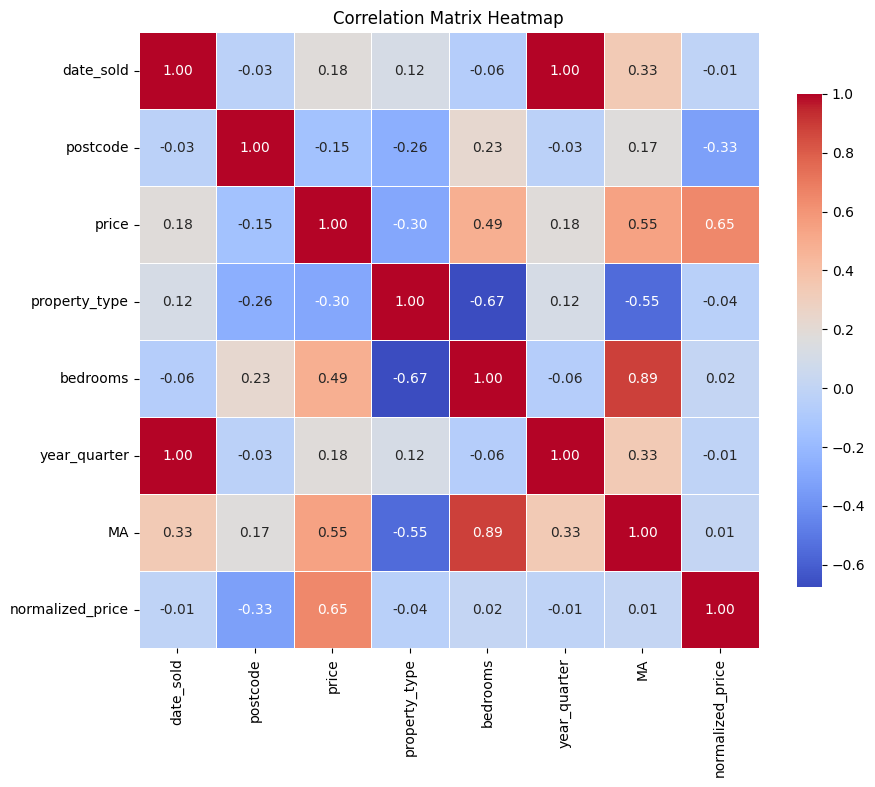

In [11]:

corr_matrix = merged_df.corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the heatmap with annotations and a color map (e.g., 'coolwarm')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': .8})

# Add a title
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()


In [12]:
def find_optimal_states(features, max_states=10):
    """
    Find the optimal number of states for HMM based on AIC and BIC.
    
    Args:
    - features (numpy.ndarray): Scaled feature matrix.
    - max_states (int): Maximum number of hidden states to test.

    Returns:
    - optimal_states_aic (int): Optimal number of states based on AIC.
    - optimal_states_bic (int): Optimal number of states based on BIC.
    - aic_scores (list): List of AIC values for each number of states.
    - bic_scores (list): List of BIC values for each number of states.
    """
    aic_scores = []
    bic_scores = []
    models = []
    
    for n_states in range(2, max_states + 1):  # Test models with 2 to max_states
        hmm = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=42, n_iter=100)
        hmm.fit(features)
        models.append(hmm)
        
        # Calculate log likelihood
        log_likelihood = hmm.score(features)
        
        # Number of parameters
        num_params = n_states**2 + 2 * n_states * features.shape[1] - 1
        
        # Calculate AIC and BIC
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(features)) * num_params - 2 * log_likelihood
        
        aic_scores.append(aic)
        bic_scores.append(bic)
    
    # Find optimal number of states
    optimal_states_aic = 2 + np.argmin(aic_scores)
    optimal_states_bic = 2 + np.argmin(bic_scores)
    
    return optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models

# Call the function and get AIC/BIC values
optimal_states_aic, optimal_states_bic, aic_scores, bic_scores, models = find_optimal_states(features, max_states=10)

print(f"Optimal number of states based on AIC: {optimal_states_aic}")
print(f"Optimal number of states based on BIC: {optimal_states_bic}")


ValueError: Input contains NaN.

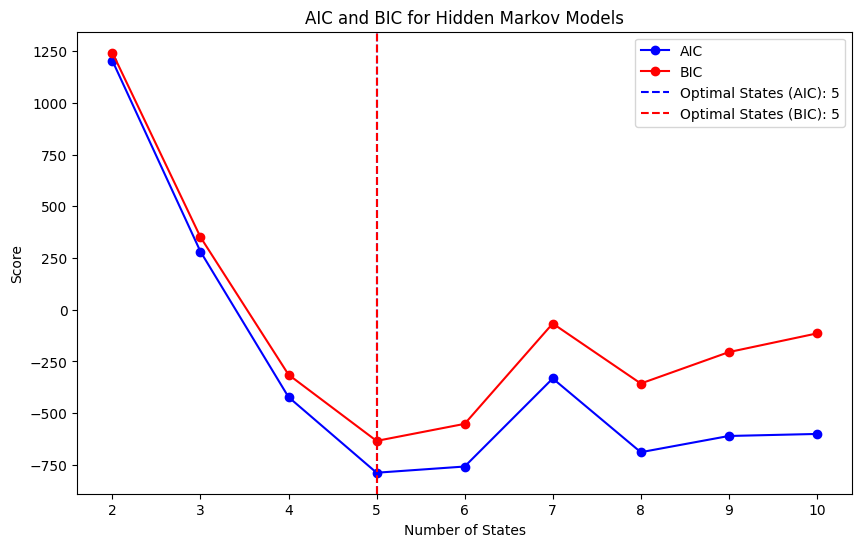

In [ ]:
# Plot AIC and BIC
states_range = range(2, len(aic_scores) + 2)

plt.figure(figsize=(10, 6))
plt.plot(states_range, aic_scores, marker='o', label='AIC', color='blue')
plt.plot(states_range, bic_scores, marker='o', label='BIC', color='red')
plt.axvline(optimal_states_aic, color='blue', linestyle='--', label=f'Optimal States (AIC): {optimal_states_aic}')
plt.axvline(optimal_states_bic, color='red', linestyle='--', label=f'Optimal States (BIC): {optimal_states_bic}')
plt.xlabel('Number of States')
plt.ylabel('Score')
plt.title('AIC and BIC for Hidden Markov Models')
plt.legend()
plt.show()


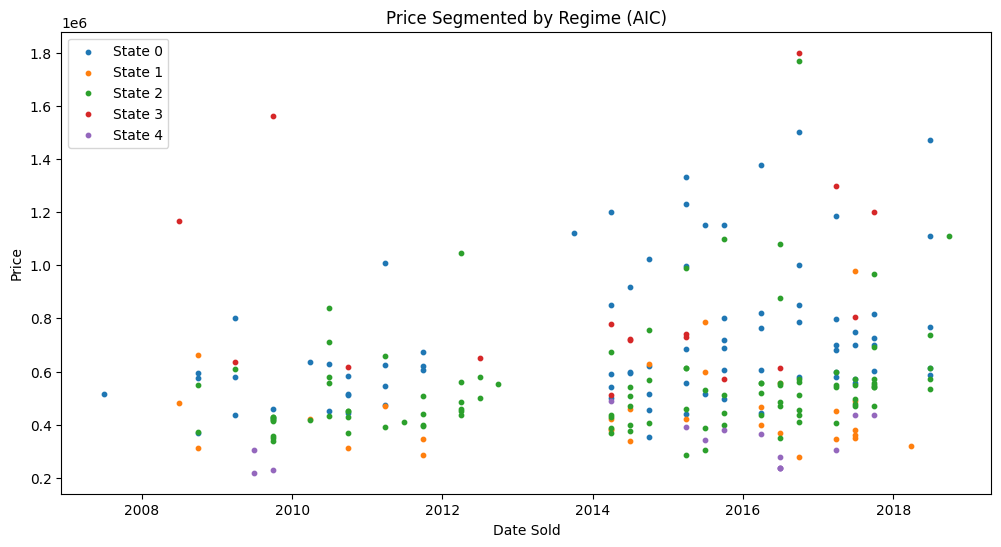

In [ ]:
# Use the model with the optimal number of states based on BIC or AIC
best_model = models[optimal_states_aic - 2]  # Adjust for 0-indexing in the models list
hidden_states = best_model.predict(features)

# Add hidden states to the dataframe
merged_df['Regime'] = hidden_states

# Plot the regimes over time
plt.figure(figsize=(12, 6))
for state in range(best_model.n_components):
    state_data = merged_df[merged_df['Regime'] == state]
    plt.scatter(state_data['datesold'], state_data['price'], label=f'State {state}', s=10)

plt.legend()
plt.title('Price Segmented by Regime (AIC)')
plt.xlabel('Date Sold')
plt.ylabel('Price')
plt.show()


1. Fit HMM to Observed Data

In [ ]:
# Train HMM with the optimal number of states
n_states = 5
hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100, random_state=42)
hmm_model.fit(features)

GaussianHMM(n_components=5, n_iter=100, random_state=42)

2. Analyze Hidden States

In [ ]:
# Predict the hidden states (regimes) for each observation
hidden_states = hmm_model.predict(features)

# Add hidden states to the dataset
merged_df['hidden_state'] = hidden_states


In [ ]:
merged_df.head(5)

,datesold,price,MA,bedrooms,propertyType,day_of_week,day_of_month,seasonality,Regime,hidden_state
15,2007-06-30,517000,548969.0,4,0,5,0,2,0,0
265,2008-06-30,480000,441854.0,2,0,0,0,2,1,1
266,2008-06-30,1165000,735904.0,5,0,0,0,2,3,3
429,2008-09-30,312000,377481.0,2,1,1,0,2,1,1
430,2008-09-30,367500,561852.0,4,0,1,0,2,0,0


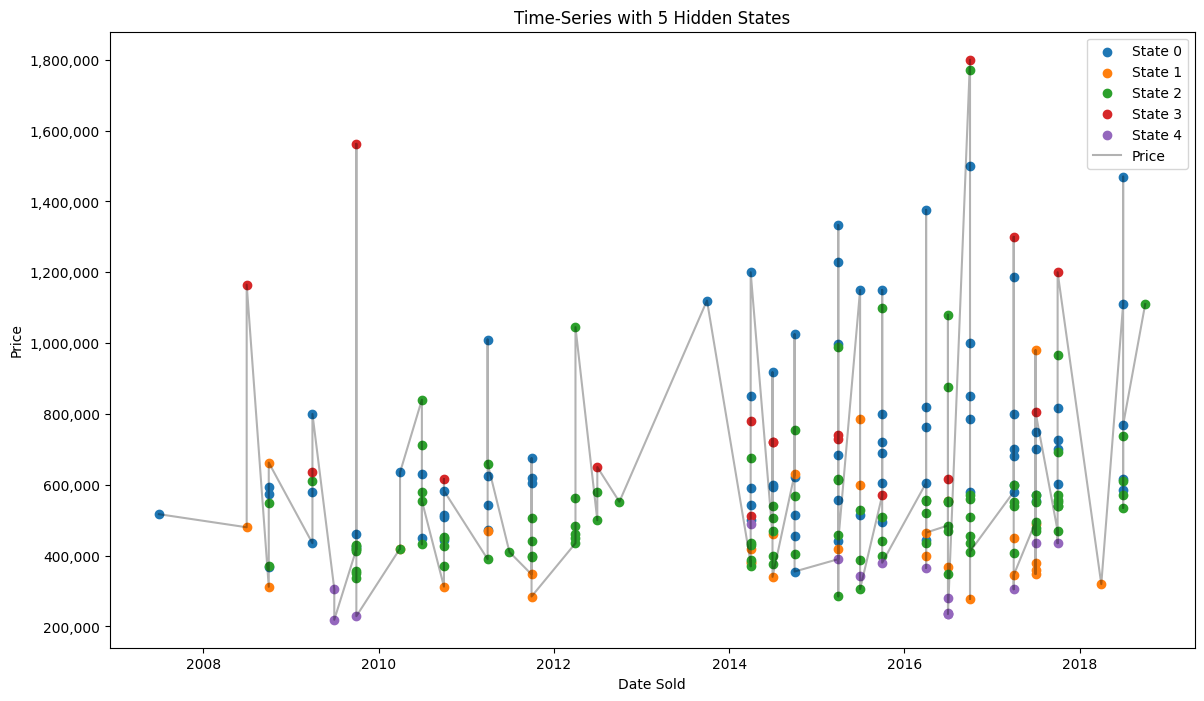

In [ ]:
plt.figure(figsize=(14, 8))

for state in range(n_states):
    # Select rows belonging to the current state
    state_indices = merged_df[merged_df['hidden_state'] == state].index
    plt.scatter(merged_df.loc[state_indices, 'datesold'], 
                merged_df.loc[state_indices, 'price'] * 1, 
                label=f"State {state}")

plt.plot(merged_df['datesold'], merged_df['price'] * 1, color="black", alpha=0.3, label="Price")

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.legend()
plt.title("Time-Series with 5 Hidden States")
plt.xlabel("Date Sold")
plt.ylabel("Price")
plt.show()

3. Average Price and Variance for each Hidden State

In [ ]:
state_stats = merged_df.groupby('hidden_state')['price'].agg(['mean', 'var', 'count'])
state_stats = round(state_stats, 2)
print("State Statistics:")
print(state_stats)


State Statistics:
                   mean           var  count
hidden_state                                
0             719584.38  6.970342e+10     80
1             448110.83  2.406143e+10     30
2             543193.93  4.313559e+10    102
3             889720.65  1.413597e+11     17
4             325712.07  7.714046e+09     15


In [ ]:
merged_df

,datesold,price,MA,bedrooms,propertyType,day_of_week,day_of_month,seasonality,Regime,hidden_state,datesold_year,year_mean_price,year_std_price,normalized_price,low_percentile,high_percentile,price_category
0,2007-06-30,517000,548969.0,4,0,5,0,2,0,0,2007,517000.000000,NaN,NaN,517000.0,517000.0,Low-End
1,2008-06-30,480000,441854.0,2,0,0,0,2,1,1,2008,564111.111111,254505.743768,-0.165244,372000.0,594000.0,Mid-Range
2,2008-06-30,1165000,735904.0,5,0,0,0,2,3,3,2008,564111.111111,254505.743768,0.472201,372000.0,594000.0,High-End
3,2008-09-30,312000,377481.0,2,1,1,0,2,1,1,2008,564111.111111,254505.743768,-0.495296,372000.0,594000.0,Low-End
4,2008-09-30,367500,561852.0,4,0,1,0,2,0,0,2008,564111.111111,254505.743768,-0.193130,372000.0,594000.0,Low-End
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2018-06-30,612000,622466.0,3,0,5,0,2,2,2,2018,766727.272727,332133.961199,-0.155286,578000.0,939500.0,Mid-Range
240,2018-06-30,615000,837295.0,4,0,5,0,2,0,0,2018,766727.272727,332133.961199,-0.114206,578000.0,939500.0,Mid-Range
241,2018-06-30,737500,622466.0,3,0,5,0,2,2,2,2018,766727.272727,332133.961199,-0.029333,578000.0,939500.0,Mid-Range
242,2018-06-30,769000,837295.0,4,0,5,0,2,0,0,2018,766727.272727,332133.961199,0.001711,578000.0,939500.0,Mid-Range


Feature Engineering Continued:

'normalized_price': Based on median price of all properties sold in a specific year for a specific number of bedrooms

In [ ]:
yearly_stats = merged_df.groupby('datesold_year')['price'].agg(['mean', 'std']).reset_index()
yearly_stats.columns = ['datesold_year', 'year_mean_price', 'year_std_price']


In [ ]:
#Normalize prices by year and bedrooms
# Extract year from 'datesold'
merged_df['datesold_year'] = merged_df['datesold'].dt.year

# Merge yearly statistics into the main DataFrame
merged_df = pd.merge(merged_df, yearly_stats, on='datesold_year', how='left')

# Normalize price using the mean price and number of bedrooms
merged_df['normalized_price'] = (
    (merged_df['price'] - merged_df['year_mean_price']) / merged_df['year_std_price']
) / merged_df['bedrooms']


In [ ]:
percentiles = merged_df.groupby('datesold_year')['price'].quantile([0.25, 0.75]).unstack()
percentiles.columns = ['low_percentile', 'high_percentile']

# Merge percentiles into the main DataFrame
merged_df = pd.merge(merged_df, percentiles, on='datesold_year', how='left')

# Categorize properties
def categorize(row):
    if row['price'] <= row['low_percentile']:
        return 'Low-End'
    elif row['price'] >= row['high_percentile']:
        return 'High-End'
    else:
        return 'Mid-Range'

merged_df['price_category'] = merged_df.apply(categorize, axis=1)


In [ ]:
yearly_stats.head(15)

,datesold_year,year_mean_price,year_std_price
0,2007,5.170000e+05,NaN
1,2008,5.641111e+05,254505.743768
2,2009,4.955895e+05,294161.136671
3,2010,5.177475e+05,126575.550016
4,2011,5.208382e+05,171123.240978
5,2012,5.719000e+05,179297.053331
6,2013,1.120000e+06,NaN
7,2014,5.654027e+05,197382.693533
8,2015,6.560080e+05,281660.764694
9,2016,6.426125e+05,386128.972201


In [ ]:
# Save n_states and X
np.savez('hmm_data.npz', n_states=n_states, X=features)

print("Variables saved to hmm_data.npz")

Variables saved to hmm_data.npz


In [ ]:
#Save merged_df
# Save the DataFrame to a CSV file
merged_df.to_csv('merged_df.csv', index=False)  # index=False to exclude row numbers
print("DataFrame saved as 'merged_df.csv'")

DataFrame saved as 'merged_df.csv'
